In [30]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  return filename

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')

Attempting to download: train.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Attempting to download: test.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!


In [3]:
train_matfile = maybe_download('train_32x32.mat')
test_matfile = maybe_download('test_32x32.mat')
extra_matfile = maybe_download('extra_32x32.mat')

Attempting to download: train_32x32.mat
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Attempting to download: test_32x32.mat
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Attempting to download: extra_32x32.mat
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!


In [1]:
import scipy.io
train_data = scipy.io.loadmat('train_32x32.mat', variable_names='X').get('X')
train_labels = scipy.io.loadmat('train_32x32.mat', variable_names='y').get('y')
test_data = scipy.io.loadmat('test_32x32.mat', variable_names='X').get('X')
test_labels = scipy.io.loadmat('test_32x32.mat', variable_names='y').get('y')
extra_data = scipy.io.loadmat('extra_32x32.mat', variable_names='X').get('X')
extra_labels = scipy.io.loadmat('extra_32x32.mat', variable_names='y').get('y')

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(extra_data.shape, extra_labels.shape)

(32, 32, 3, 73257) (73257, 1)
(32, 32, 3, 26032) (26032, 1)
(32, 32, 3, 531131) (531131, 1)


In [3]:
test_labels[0]

array([5], dtype=uint8)

In [21]:
test_data[0,:,:].shape

(32, 3, 26032)

In [6]:
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0
extra_labels[extra_labels == 10] = 0

In [31]:
# Build Validation Dataset and Labels Based on the Methods in This Paper:
# [https://arxiv.org/pdf/1204.3968.pdf]

import random

random.seed()

n_labels = 10
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []
for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,0] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,0] == (i))[0][400:].tolist())
    valid_index2.extend(np.where(extra_labels[:,0] == (i))[0][:200].tolist())
    train_index2.extend(np.where(extra_labels[:,0] == (i))[0][200:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

valid_data = np.concatenate((extra_data[:,:,:,valid_index2], train_data[:,:,:,valid_index]), axis=3).transpose((3,0,1,2))
valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)[:,0]
train_data_t = np.concatenate((extra_data[:,:,:,train_index2], train_data[:,:,:,train_index]), axis=3).transpose((3,0,1,2))
train_labels_t = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)[:,0]
test_data = test_data.transpose((3,0,1,2))
test_labels = test_labels[:,0]

print(train_data_t.shape, train_labels_t.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

(548490, 32, 32, 3) (548490,)
(26032, 32, 32, 3) (26032,)
(5400, 32, 32, 3) (5400,)


In [52]:
def check_xy(data, label, j):
    x = Image.fromarray(data[j])
    y = label[j]
    # x.show()
    return x, y

In [32]:
test_data[1].shape

(32, 32, 3)

In [40]:
test_labels[1]

5

In [37]:
from PIL import Image

In [38]:
img = Image.fromarray(test_data[0])

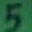

In [39]:
img

In [58]:
image, label = check_xy(test_data, test_labels, 99)

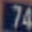

In [59]:
image

In [60]:
label

7

In [33]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)
    # Use the Conversion Method in This Paper:
    # [http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf]
    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray

train_data_c = im2gray(train_data_t)[:,:,:,0]
test_data_c = im2gray(test_data)[:,:,:,0]
valid_data_c = im2gray(valid_data)[:,:,:,0]

print(train_data_c.shape, train_labels_t.shape)
print(test_data_c.shape, test_labels.shape)
print(valid_data_c.shape, valid_labels.shape)

(548490, 32, 32) (548490,)
(26032, 32, 32) (26032,)
(5400, 32, 32) (5400,)


In [34]:
def GCN(image, min_divisor=1e-4):
    """Global Contrast Normalization"""
    
    imsize = image.shape[0]
    mean = np.mean(image, axis=(1,2), dtype=float)
    std = np.std(image, axis=(1,2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    image_GCN = np.zeros(image.shape, dtype=float)
    
    for i in np.arange(imsize):
        image_GCN[i,:,:] = (image[i,:,:] - mean[i]) / std[i]
        
    return image_GCN

train_data_GCN = GCN(train_data_c)
test_data_GCN = GCN(test_data_c)
valid_data_GCN = GCN(valid_data_c)

print(train_data_GCN.shape, train_labels_t.shape)
print(test_data_GCN.shape, test_labels.shape)
print(valid_data_GCN.shape, valid_labels.shape)

(548490, 32, 32) (548490,)
(26032, 32, 32) (26032,)
(5400, 32, 32) (5400,)


In [35]:
test_data_GCN[0]

array([[0.27395864, 0.33465826, 0.34157871, ..., 0.29967964, 0.36037926,
        0.05753679],
       [0.33465826, 0.33465826, 0.34157871, ..., 0.29967964, 0.31417616,
        0.05753679],
       [0.35906802, 0.2983684 , 0.41976764, ..., 0.31417616, 0.28546237,
        0.07137769],
       ...,
       [1.22270359, 1.28340321, 1.16200397, ..., 0.97962587, 0.95783252,
        0.78265411],
       [1.10130435, 1.16200397, 1.04060473, ..., 0.95783252, 0.94726366,
        0.7651648 ],
       [0.97990511, 0.97990511, 0.85850587, ..., 0.90405335, 0.88656404,
        0.7790057 ]])

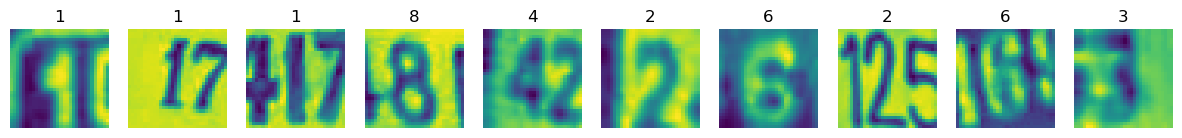

In [10]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels_t.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels_t[j], loc='center')
    ax[i].imshow(train_data_GCN[j,:,:])

In [11]:
pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    #'train_dataset': train_data_GCN,
    'train_labels': train_labels_t,
    'valid_dataset': valid_data_GCN,
    'valid_labels': valid_labels,
    'test_dataset': test_data_GCN,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 263037003


In [12]:
pickle_file = 'SVHN1.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset1': train_data_GCN[:200000],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1638400186


In [13]:
pickle_file = 'SVHN2.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset2': train_data_GCN[200000:400000],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1638400186


In [14]:
pickle_file = 'SVHN3.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset3': train_data_GCN[400000:],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1625194682


In [15]:
# Create a Logistic Regression Classifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, shuffle=True, verbose=0,\
                    n_jobs=4, random_state=None, learning_rate='optimal')
clf.fit(train_data_c.reshape(train_data_GCN.shape[0],-1), train_labels_t)
train_prediction = clf.predict(train_data_GCN.reshape(train_data_GCN.shape[0],-1))
valid_prediction = clf.predict(valid_data_GCN.reshape(valid_data_GCN.shape[0],-1))

print('Training score is', clf.score(train_data_GCN.reshape(train_data_GCN.shape[0],-1), train_labels_t))
print('Validation score is', clf.score(valid_data_GCN.reshape(valid_data_GCN.shape[0],-1), valid_labels))

print('Classification report of training data:\n', classification_report(train_labels_t, train_prediction))
print('Confusion Matrix of training data:\n', confusion_matrix(train_labels_t, train_prediction))

print('Classification report of validation data:\n', classification_report(valid_labels, valid_prediction))
print('Confusion Matrix of validation data:\n', confusion_matrix(valid_labels, valid_prediction))

D:\anaconda3\envs\fl37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Training score is 0.1740593060021257
Validation score is 0.10166666666666667


D:\anaconda3\envs\fl37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\fl37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\fl37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report of training data:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     49898
           1       0.17      0.99      0.30    103821
           2       0.00      0.00      0.00     84725
           3       0.00      0.00      0.00     68662
           4       0.00      0.00      0.00     57491
           5       0.00      0.00      0.00     59772
           6       0.00      0.00      0.00     46709
           7       0.00      0.00      0.00     48992
           8       0.14      0.03      0.05     39803
           9       0.00      0.00      0.00     38515

    accuracy                           0.17    598388
   macro avg       0.03      0.10      0.04    598388
weighted avg       0.04      0.17      0.06    598388

Confusion Matrix of training data:
 [[     0  49246      0      0      0      0      0      0    652      0]
 [     0 102800      0      0      0      0      0      0   1021      0]
 [     0  83487   

D:\anaconda3\envs\fl37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\fl37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\fl37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
